# Iris Closure Calibration

The 'standard' OPT setup is to set the DOF to be half the sample size. This places a restriction on the magnification, hence the resolution we can achieve.

The f number N is defined to be

$$N = \frac{f}{D}$$

where $f$ is the focal length of the lens and $D$ is the diameter.

We can assume that the intensity is proportional to the square of the diameter of the iris.

$$I \propto D^{2} \propto N^{-2}$$

In [2]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

In [3]:
FORWARD_CLOSURE_IMAGE =  '../OPT Shared files/2022-10-27/2022-10-27 iris closure forward/iris_closure_forward.tif'
forward = io.imread(FORWARD_CLOSURE_IMAGE)

BACKWARD_CLOSURE_IMAGE =  '../OPT Shared files/2022-10-27/2022-10-27 iris closure backward/iris_closure_backward.tif'
backward = io.imread(BACKWARD_CLOSURE_IMAGE)

def get_average_and_std(image_stack):
    return np.average(image_stack, axis = (1,2)), np.std(image_stack, axis = (1,2))

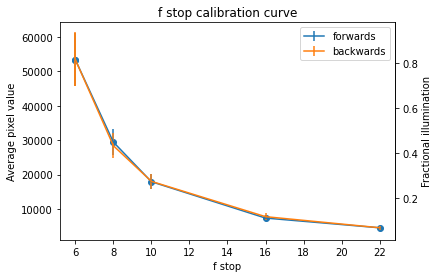

In [4]:
fwd_avg, fwd_std = get_average_and_std(forward)
back_avg, back_std = get_average_and_std(backward)
apertures = np.array([6, 6, 8, 10, 16, 22])

fig, ax = plt.subplots()
ax.scatter(apertures, fwd_avg)
ax.errorbar(apertures, fwd_avg, yerr=fwd_std, label='forwards')
ax.errorbar(apertures[::-1], back_avg, yerr=back_std, label='backwards')

secax_y = ax.secondary_yaxis(
    'right', functions=(lambda x: x/65565, lambda x: x*65565))
secax_y.set_ylabel(r'Fractional illumination')

plt.title('f stop calibration curve')
plt.ylabel('Average pixel value')
plt.xlabel('f stop')

plt.legend()

Text(0.5, 0, '$1/f\\ stop ^2$ ')

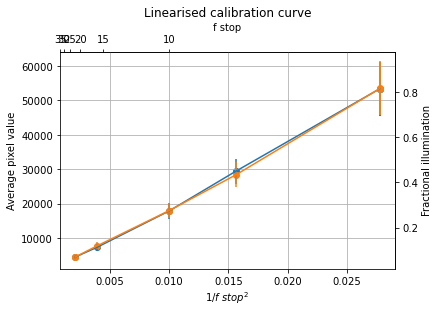

In [5]:
fig, ax = plt.subplots()

inv_aperture_squared = 1/(apertures**2)
plt.scatter(inv_aperture_squared, fwd_avg)
plt.scatter(inv_aperture_squared[::-1], back_avg)
plt.errorbar(inv_aperture_squared, fwd_avg, yerr=fwd_std, label='forwards')
plt.errorbar(inv_aperture_squared[::-1], back_avg, yerr=back_std, label='backwards')

def one_over_sqrt(x):
    """Vectorized 1/x, treating x==0 manually"""
    x = np.array(x).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = 1 / np.sqrt(x[~near_zero])
    return x

def one_over_square(x):
    """Vectorized 1/x, treating x==0 manually"""
    x = np.array(x).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = 1 / (x[~near_zero])**2
    return x


secax_y = ax.secondary_yaxis(
    'right', functions=(lambda x: x/65565, lambda x: x*65565))
secax_y.set_ylabel(r'Fractional illumination')

secax_x = ax.secondary_xaxis(
    'top', functions=(one_over_sqrt, one_over_square))
secax_x.set_xlabel(r'f stop')
secax_x.set_xlim([6,22])

plt.grid()
plt.title('Linearised calibration curve')
plt.ylabel('Average pixel value')
plt.xlabel('$1/f\ stop ^2$ ')

# Resolution

We want to determine whether the system is diffraction limited or not.

Two point sources are just resolved if their images do not 'blur together'.

For a circular aperture, this is defined by the Airy disk-- which is also called the **Rayleigh criterion**.

The distance between the Airy disk's peak and its first minimum is given by
$$R_{airy} = \frac{0.61 \lambda}{NA}$$

For a system with no magnification, the separation of the point sources will be 

$$x \geq R_{airy}$$ 

for resolution and this is called a **diffraction limited system**.

Another limitation is our pixel size because we are sampling the diffraction pattern using our detector. In absence of diffraction, this is the only limit to our resolution.

$$x \geq \frac{2e}{M}$$

where $M$ is the magnification of the system and $e$ is the pixel size.

A **pixel limited system** means that the pixel sizes are great compared to the size of the Airy disc.

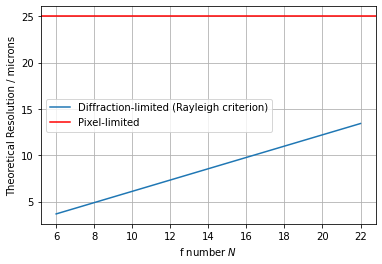

In [6]:
def R_airy(lamb, NA):
    return 0.61* lamb/ NA
f_nums = np.array([6, 8, 10, 16, 22])
NA = 1/(2*f_nums)
e = 6.25
M = 0.5

airy_thresh = 2*e/M

plt.plot(f_nums, R_airy(500e-9, NA)*1e6, label='Diffraction-limited (Rayleigh criterion)')


plt.axhline(y=airy_thresh, color='r', linestyle='-', label='Pixel-limited')

plt.ylabel('Theoretical Resolution / microns')
plt.xlabel('f number $N$')
plt.grid()
plt.legend()

# Defocus Model
Stokeseth Approximation

/var/folders/55/y8nplzr92z3002w35fdrm2wc0000gn/T/ipykernel_86071/386402461.py:7: RuntimeWarning: invalid value encountered in true_divide
  return 2*(1-0.69*s + 0.0076*s**2 + 0.043*s**3)* jv(1, (a - 0.5*a*s))/ (a - 0.5*a*s)
/var/folders/55/y8nplzr92z3002w35fdrm2wc0000gn/T/ipykernel_86071/386402461.py:7: RuntimeWarning: invalid value encountered in true_divide
  return 2*(1-0.69*s + 0.0076*s**2 + 0.043*s**3)* jv(1, (a - 0.5*a*s))/ (a - 0.5*a*s)


Text(0.5, 1.0, 'Stokeseth Approximation')

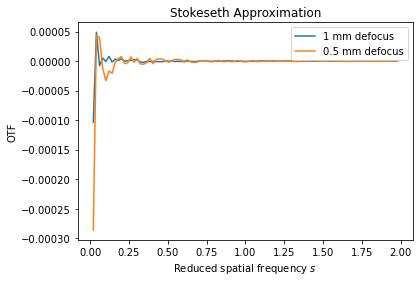

In [21]:
from scipy.special import jv

def stokeseth(s, w, lamb):
    # w: defocus
    # lamb: wavelength
    a = 4*np.pi*w*s/lamb
    return 2*(1-0.69*s + 0.0076*s**2 + 0.043*s**3)* jv(1, (a - 0.5*a*s))/ (a - 0.5*a*s)

s = np.linspace(0,2,100)
vals = stokeseth(s, 1e-3, 500e-9)
plt.plot(s, vals, label='1 mm defocus')
plt.plot(s, stokeseth(s, .5e-3, 500e-9), label='0.5 mm defocus')
# plt.plot(s, stokeseth(s, .5e-4, 500e-9), label='0.05 mm defocus')
plt.legend()
plt.ylabel('OTF')
plt.xlabel('Reduced spatial frequency $s$')
plt.title('Stokeseth Approximation')